# Imports

In [6]:
import gdown
import cv2
import numpy as np
import os
import skorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.datasets
import sklearn.model_selection
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.preprocessing
import importlib
import extracting_features_fn as eff
importlib.reload(eff)
import lipread_model as lrm
importlib.reload(lrm)

<module 'lipread_model' from 'C:\\Users\\admin\\Documents\\GitHub\\final-project-submission-IsuruPabasara\\lipread_model.py'>

# Data downloading

In [5]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=c45bf51d-3601-4f5c-a271-f382204128fb
To: C:\Users\admin\Documents\EE5380\Project\data.zip
100%|██████████| 423M/423M [00:13<00:00, 30.3MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

# Manual Word Extraction

In [2]:
if(os.path.exists('./graydata')==False):
    os.makedirs('./graydata')
if(os.path.exists('./croppeddata')==False):
    os.makedirs('./croppeddata')
    
eff.FeatureExtractor.lipExtraction()

In [4]:
if(os.path.exists('./words')==False):
    os.makedirs('./words')
eff.FeatureExtractor.wordExtraction()

# Data loading

In [12]:
vocab = ['now','bin','white','soon','green','lay','blue','place','again','please']
#vocab = ['now','bin','white','soon','green']
#vocab = ['now','bin']
vocabsize = len(vocab)

def char_to_num(word):
    return vocab.index(word)

def num_to_char(numbers):
    return vocab[numbers]

def load_data(filename, folder):
    frames = eff.FeatureExtractor.load_video(filename, folder)
    return frames

In [13]:
# Excecuting video loading
data_x_temp = []
data_y_temp = []
for folder in vocab:
    if(os.path.exists('./words/' + folder)==True):
        files = os.listdir('./words/' + folder)
        for filename in files:
            if(filename.split('.')[1]=='mp4'):
                frames = load_data(filename.split('.')[0], folder)
                data_x_temp.append(frames)
                data_y_temp.append(char_to_num(folder))
                
data_y = np.array(data_y_temp).astype('int64')
data_x = np.swapaxes(np.array(data_x_temp).astype('float32'),1,2)

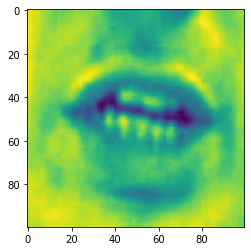

In [14]:
from matplotlib import pyplot as plt
plt.imshow(data_x[500][0][5])

# Test train split

In [15]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    data_x,
    data_y,
    test_size=0.3,
    random_state=1
)

# Monitor functions

In [16]:
def readSentence(model, videoInput, targetSentence):
    inLetters = num_to_char(targetSentence)
    print('Input:',inLetters)

    prediction = model.predict(np.expand_dims(videoInput,axis=0))
    outSentence = num_to_char(int(np.argmax(prediction,axis=1)))
    print('Output:',outSentence)

In [17]:
class ProduceExample(skorch.callbacks.Callback):
    def on_epoch_end(self, net, dataset_train, dataset_valid, **kwargs) -> None:
        readSentence(net, dataset_train[0][0],dataset_train[0][1])

# LipRead model

In [18]:
# Defining regressor
model_lip = skorch.NeuralNet(
    lrm.LipNet,
    optimizer=torch.optim.SGD,
    criterion = torch.nn.CrossEntropyLoss,
    max_epochs=50,
    lr=0.001,
    callbacks=[('cb1',ProduceExample),
               ('cb2',skorch.callbacks.EarlyStopping(patience=10))]
)

In [19]:
# Hyperparameters
model_lip.module__dropout_p  = 0.3
model_lip.module__conv_sizes = (x_train.shape[1],x_train.shape[1])
model_lip.module__conv_kernel_sizes = (2,)
model_lip.module__act_fn_maxpool = nn.ReLU()
model_lip.module__act_fn_dense = nn.ReLU()
model_lip.module__img_T =x_train.shape[2]
model_lip.module__img_H =x_train.shape[3]
model_lip.module__img_W = x_train.shape[4]
model_lip.module__vocabsize = vocabsize
#for vocabsize=2/vocabsize=5
#model_lip.module__gru_size = 1024*(vocabsize-1)
#for vocabsize=10
model_lip.module__gru_size = 1024*(vocabsize)

In [112]:
# Fitting the model
model_lip.fit(x_train, y_train)

Input: soon
Output: soon
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        1.5896        1.5341  64.0386


C:\Users\admin\AppData\Local\Temp\ipykernel_27140\4049403668.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outSentence = num_to_char(int(np.argmax(prediction,axis=1)))


Input: soon
Output: soon
      2        1.5654        1.5142  67.3129
Input: soon
Output: soon
      3        1.5490        1.4993  68.0052
Input: soon
Output: soon
      4        1.5362        1.4866  68.4010
Input: soon
Output: soon
      5        1.5348        1.4789  71.6265
Input: soon
Output: soon
      6        1.5341        1.4741  80.0654
Input: soon
Output: soon
      7        1.5251        1.4638  77.7387
Input: soon
Output: soon
      8        1.5162        1.4624  74.2336
Input: soon
Output: soon
      9        1.5098        1.4585  69.5567
Input: soon
Output: soon
     10        1.5099        1.4498  66.2598
Input: soon
Output: soon
     11        1.5144        1.4451  74.6670
Input: soon
Output: soon
     12        1.5055        1.4394  68.2431
Input: soon
Output: soon
     13        1.5035        1.4381  70.4363
Input: soon
Output: soon
     14        1.5044        1.4457  66.4281
Input: soon
Output: soon
     15        1.5143        1.4411  66.8954
Input: soon
Output: 

<class 'skorch.net.NeuralNet'>[initialized](
  module_=LipNet(
    (act_fn_maxpool): ReLU()
    (act_fn_dense): ReLU()
    (cnnetwork): ModuleList(
      (0): Conv3d(1, 1, kernel_size=(1, 2, 2), stride=(1, 1, 1))
      (1): Dropout3d(p=0.3, inplace=False)
    )
    (gru1): GRU(9801, 4096, batch_first=True)
    (dense): Linear(in_features=40960, out_features=5, bias=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.3, inplace=False)
  ),
)

# Test accuracy

In [130]:
preds = model_lip.predict(x_test)

In [131]:
predwords = [num_to_char(x) for x in np.argmax(preds,axis=1)]
targwords = [num_to_char(x) for x in y_test]
equalwords = [predwords[idx]==targwords[idx] for idx in range(len(predwords))]
equalcount = equalwords.count(True)
pred_accuracy = (equalcount/len(targwords)) * 100
print("Test accuracy is",pred_accuracy)

Test accuracy is 58.35694050991501


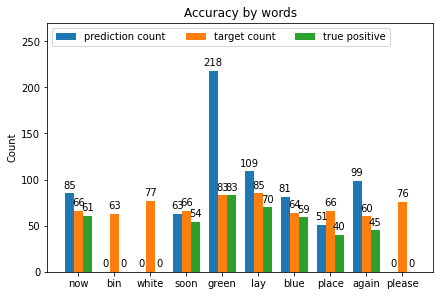

In [135]:
perfwor = []
perfpred = []
perftarg = []
perfpos = []
for word in vocab:
    predwordcount = [predwords[idx]==word for idx in range(len(predwords))]
    targwordcount = [targwords[idx]==word for idx in range(len(predwords))]
    truepos = [np.all([predwords[idx]==targwords[idx],predwords[idx]==word]) for idx in range(len(predwords))]
    perfwor.append(word)
    perfpred.append(predwordcount.count(True))
    perftarg.append(targwordcount.count(True))
    perfpos.append(truepos.count(True))
chartData = {
    "prediction count":perfpred,
    "target count":perftarg,
    "true positive":perfpos
}

x = np.arange(len(perfwor))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in chartData.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Count')
ax.set_title('Accuracy by words')
ax.set_xticks(x + width, perfwor)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 270)

plt.show()

# Save if model is better than existing

In [116]:
save_name = './models/model_'+str(int(pred_accuracy))+'_point.pkl'
model_lip.save_params(f_params=save_name)

# Load a pretrained model

In [ ]:
url1 = 'https://drive.google.com/uc?id=1iDWGmiPGmvyskg46o7DHaBhlZ72xY6kJ'
url2 = 'https://drive.google.com/uc?id=1Hlg6HECPdBY-RoSNSsxVmDDb39YZ9l4W'
url3 = 'https://drive.google.com/uc?id=1YQvVD8uRHUdrW2DLXHhvHUUTbKsXYXGD'
output1 = 'modelsn/model_2V_90_point.pkl'
output2 = 'modelsn/model_5V_66_point.pkl'
output3 = 'modelsn/model_10V_59_point.pkl'
if (os.path.exists('./modelsn')==False):
    os.makedirs('./modelsn')
gdown.download(url1, output1, quiet=False)
gdown.download(url2, output2, quiet=False)
gdown.download(url3, output3, quiet=False)

In [21]:
output3 = 'modelsn/model_10V_59_point.pkl'
model_lip.initialize()
model_lip.load_params(f_params = output3)

Re-initializing module because the following parameters were re-set: act_fn_dense, act_fn_maxpool, conv_kernel_sizes, conv_sizes, dropout_p, gru_size, img_H, img_T, img_W, vocabsize.
Re-initializing criterion.
Re-initializing optimizer.
